In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV







### Fixing workable df

In [25]:
df_csv = pd.read_csv('Misdrijven_W_B.csv', sep=';')
df_xls = pd.read_excel('kwb-2018.xls')
df_csv = df_csv.rename(columns={'WijkenEnBuurten': 'gwb_code_10'})
df = df_xls.merge(df_csv, on = 'gwb_code_10', how='inner')

df =df.replace({".": np.nan})

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.')
        df[col] = pd.to_numeric(df[col], errors='ignore')






/var/folders/q8/wmshq4m10v9267157w6sf1ym0000gn/T/ipykernel_26923/1128133705.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df =df.replace({".": np.nan})
/var/folders/q8/wmshq4m10v9267157w6sf1ym0000gn/T/ipykernel_26923/1128133705.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [26]:


numeric_cols = df.select_dtypes(include=['float64','int64']).columns
numeric_unique_counts = df[numeric_cols].nunique().sort_values()
numeric_unique_counts.head(30)

#some category collumns were changed to numeric. In this case ste_mvs
#should be converted back into a category variable

df['ste_mvs'] = df['ste_mvs'].astype('object')

### Computing missing value treshold


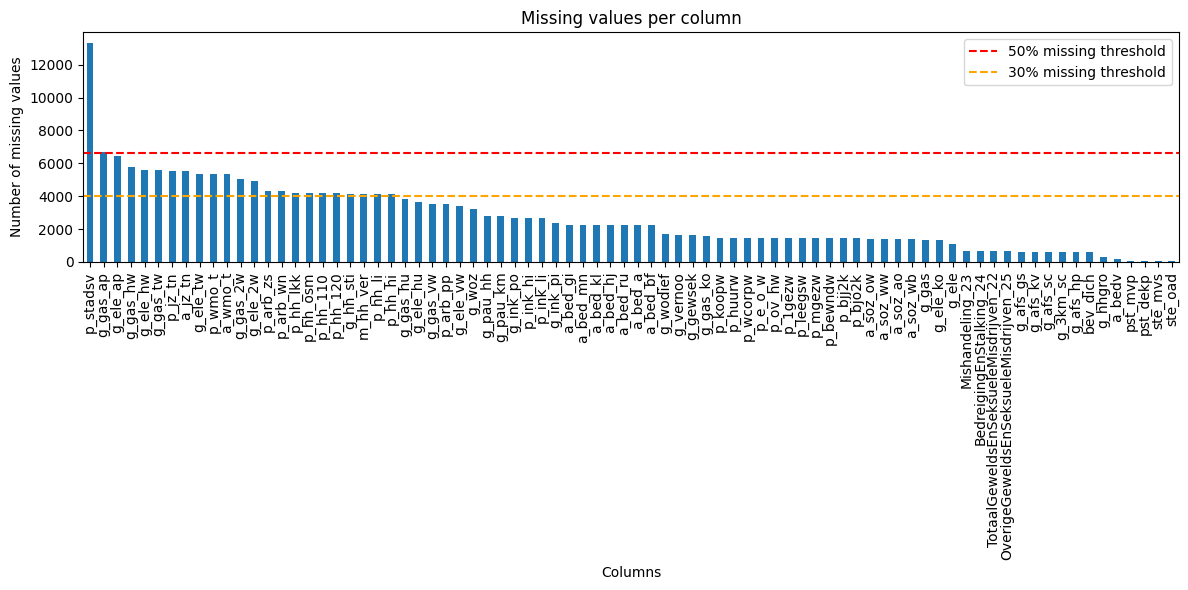

In [27]:
missing = df.isna().sum()
missing = missing[missing>0].sort_values(ascending=False)

total_rows = len(df)
missing_perc_50 = 0.5 * total_rows
missing_perc_30 = 0.3 * total_rows


plt.figure(figsize=(12,6))
missing.plot(kind='bar')
plt.axhline(missing_perc_50, color = 'red', linestyle = '--', label = '50% missing threshold')
plt.axhline(missing_perc_30, color = 'orange', linestyle = '--', label = '30% missing threshold')
plt.title("Missing values per column")
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:

df = df.dropna(subset=['TotaalGeweldsEnSeksueleMisdrijven_22'])
df = df[df['a_inw']>0]

#p_stadsv has more than 50% missing values
df = df.drop(["p_stadsv"], axis=1)

#the following add up to TotaalGeweldsEnSeksueleMisdrijven_22
df = df.drop(["Mishandeling_23", "BedreigingEnStalking_24", "OverigeGeweldsEnSeksueleMisdrijven_25"], axis=1)

#redundant rows
df = df.drop(["ind_wbi", "gwb_code_8"], axis=1)

#contain several missing values and relate to criminality
df = df.drop(["g_wodief", "g_vernoo", "g_gewsek"], axis =1)

df['ste_mvs'] = df['ste_mvs'].fillna(df['ste_mvs'].mode()[0])

#--> note that i have not yet disregarded columns with missing values >30% and <50%.
# What should we do with those?

/var/folders/q8/wmshq4m10v9267157w6sf1ym0000gn/T/ipykernel_26923/848907292.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ste_mvs'] = df['ste_mvs'].fillna(df['ste_mvs'].mode()[0])


### Handling outliers in dependent variable
later on we wil use population (a_inw)  and total violent crimes (TotaalGeweldsEnSeksueleMisdrijven_22) to calculate the amount of crimes per 1000. However we will run into a few problems that can be discussed in paper:
- population of zero makes infinite large numbers
- if population < total violent crimes the number blows up.
- What upper bound to choose? 

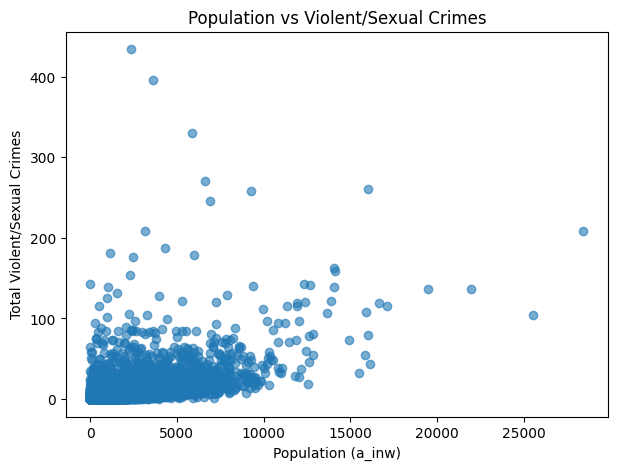

In [29]:
plt.figure(figsize=(7,5))
plt.scatter(df["a_inw"], df["TotaalGeweldsEnSeksueleMisdrijven_22"], alpha=0.6)
plt.xlabel("Population (a_inw)")
plt.ylabel("Total Violent/Sexual Crimes")
plt.title("Population vs Violent/Sexual Crimes")
plt.show()


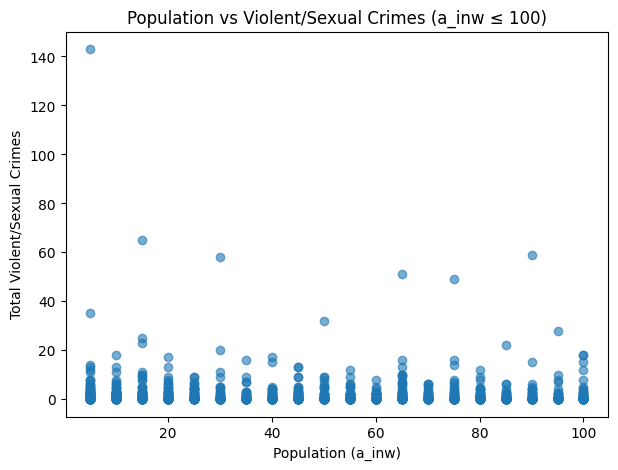

In [30]:
subset = df[df["a_inw"] <= 100]

plt.figure(figsize=(7,5))
plt.scatter(subset["a_inw"], subset["TotaalGeweldsEnSeksueleMisdrijven_22"], alpha=0.6)
plt.xlabel("Population (a_inw)")
plt.ylabel("Total Violent/Sexual Crimes")
plt.title("Population vs Violent/Sexual Crimes (a_inw ≤ 100)")
plt.show()


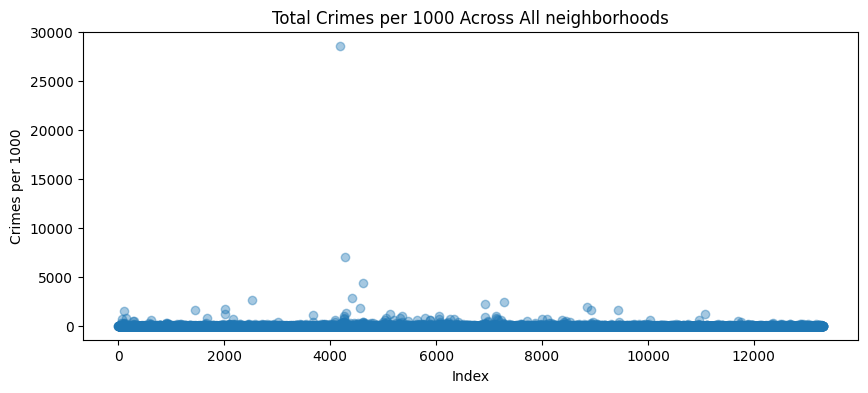

Original rows: 12381
Rows after trimming: 12060
Rows removed: 321


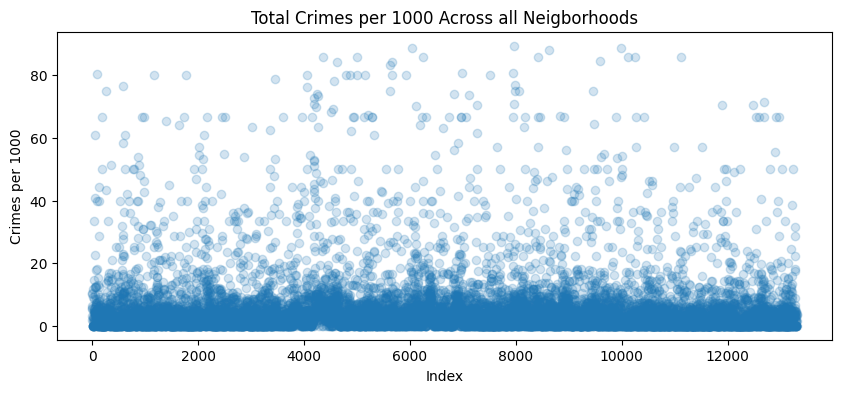

In [31]:
upper_quantile = 0.95


df["Total_Crimes_Per_1000"]= (df["TotaalGeweldsEnSeksueleMisdrijven_22"] / df["a_inw"])* 1000

df = df.dropna(subset=["Total_Crimes_Per_1000"])
df = df.drop(columns=["TotaalGeweldsEnSeksueleMisdrijven_22", "a_inw"])

plt.figure(figsize=(10,4))
plt.scatter(df.index, df["Total_Crimes_Per_1000"], alpha=0.4)
plt.title("Total Crimes per 1000 Across All neighborhoods")
plt.xlabel("Index")
plt.ylabel("Crimes per 1000")
plt.show()

Q1 = df["Total_Crimes_Per_1000"].quantile(0.25)
Q3 = df["Total_Crimes_Per_1000"].quantile(upper_quantile)
IQR = Q3 - Q1


upper_bound = Q3 + 1.5 * IQR

df_iqr = df[(df["Total_Crimes_Per_1000"] <= upper_bound)].copy()

print("Original rows:", len(df))
print("Rows after trimming:", len(df_iqr))
print("Rows removed:", len(df) - len(df_iqr))

plt.figure(figsize=(10,4))
plt.scatter(df_iqr.index, df_iqr["Total_Crimes_Per_1000"], alpha=0.2)
plt.title("Total Crimes per 1000 Across all Neigborhoods")
plt.xlabel("Index")
plt.ylabel("Crimes per 1000")
plt.show()

### train and test + scaling and imputing missing values


In [32]:
random_state = 11
df = df_iqr

y = df["Total_Crimes_Per_1000"]
X = df.drop(["Total_Crimes_Per_1000"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= random_state)

In [33]:

#KNN imputer to fill in missing values
id_cols = ['gwb_code_10', 'regio', 'gm_naam', 'recs']
X_train = X_train.drop(id_cols, errors='ignore')
X_test = X_test.drop(id_cols, errors='ignore')


ordinal_cols = ["ste_mvs"]

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scale_cols = [col for col in num_cols if col not in ordinal_cols]

X_train_num = X_train[scale_cols]
X_test_num = X_test[scale_cols]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

X_train_num_imputed_scaled = pipe.fit_transform(X_train_num)
X_test_num_imputed_scaled = pipe.transform(X_test_num)

X_train_num_imputed_scaled= pd.DataFrame(X_train_num_imputed_scaled, columns = scale_cols, index = X_train.index)
X_test_num_imputed_scaled= pd.DataFrame(X_test_num_imputed_scaled, columns = scale_cols, index = X_test.index)

X_train_ord = X_train[ordinal_cols]
X_test_ord = X_test[ordinal_cols]

X_train_final = pd.concat([X_train_num_imputed_scaled, X_train_ord], axis=1)
X_test_final = pd.concat([X_test_num_imputed_scaled, X_test_ord], axis=1)



### Possible feature selection (can be ignored)

In [34]:
#feature selection 
feature_selection = SelectKBest(score_func=mutual_info_regression, k=20)

feature_selection.fit(X_train_final, y_train)
X_train_selected = feature_selection.transform(X_train_final)
X_test_selected = feature_selection.transform(X_test_final)

selected_features = X_train_final.columns[feature_selection.get_support()]
print("Selected features:", list(selected_features))

Selected features: ['a_man', 'a_vrouw', 'a_00_14', 'a_15_24', 'a_25_44', 'a_45_64', 'a_ongeh', 'a_gehuwd', 'a_gesch', 'a_nw_all', 'a_hh', 'a_1p_hh', 'a_hh_z_k', 'a_hh_m_k', 'a_woning', 'a_inkont', 'a_soz_ao', 'a_soz_ww', 'a_pau', 'a_bst_b']


### Data exploration for selected features

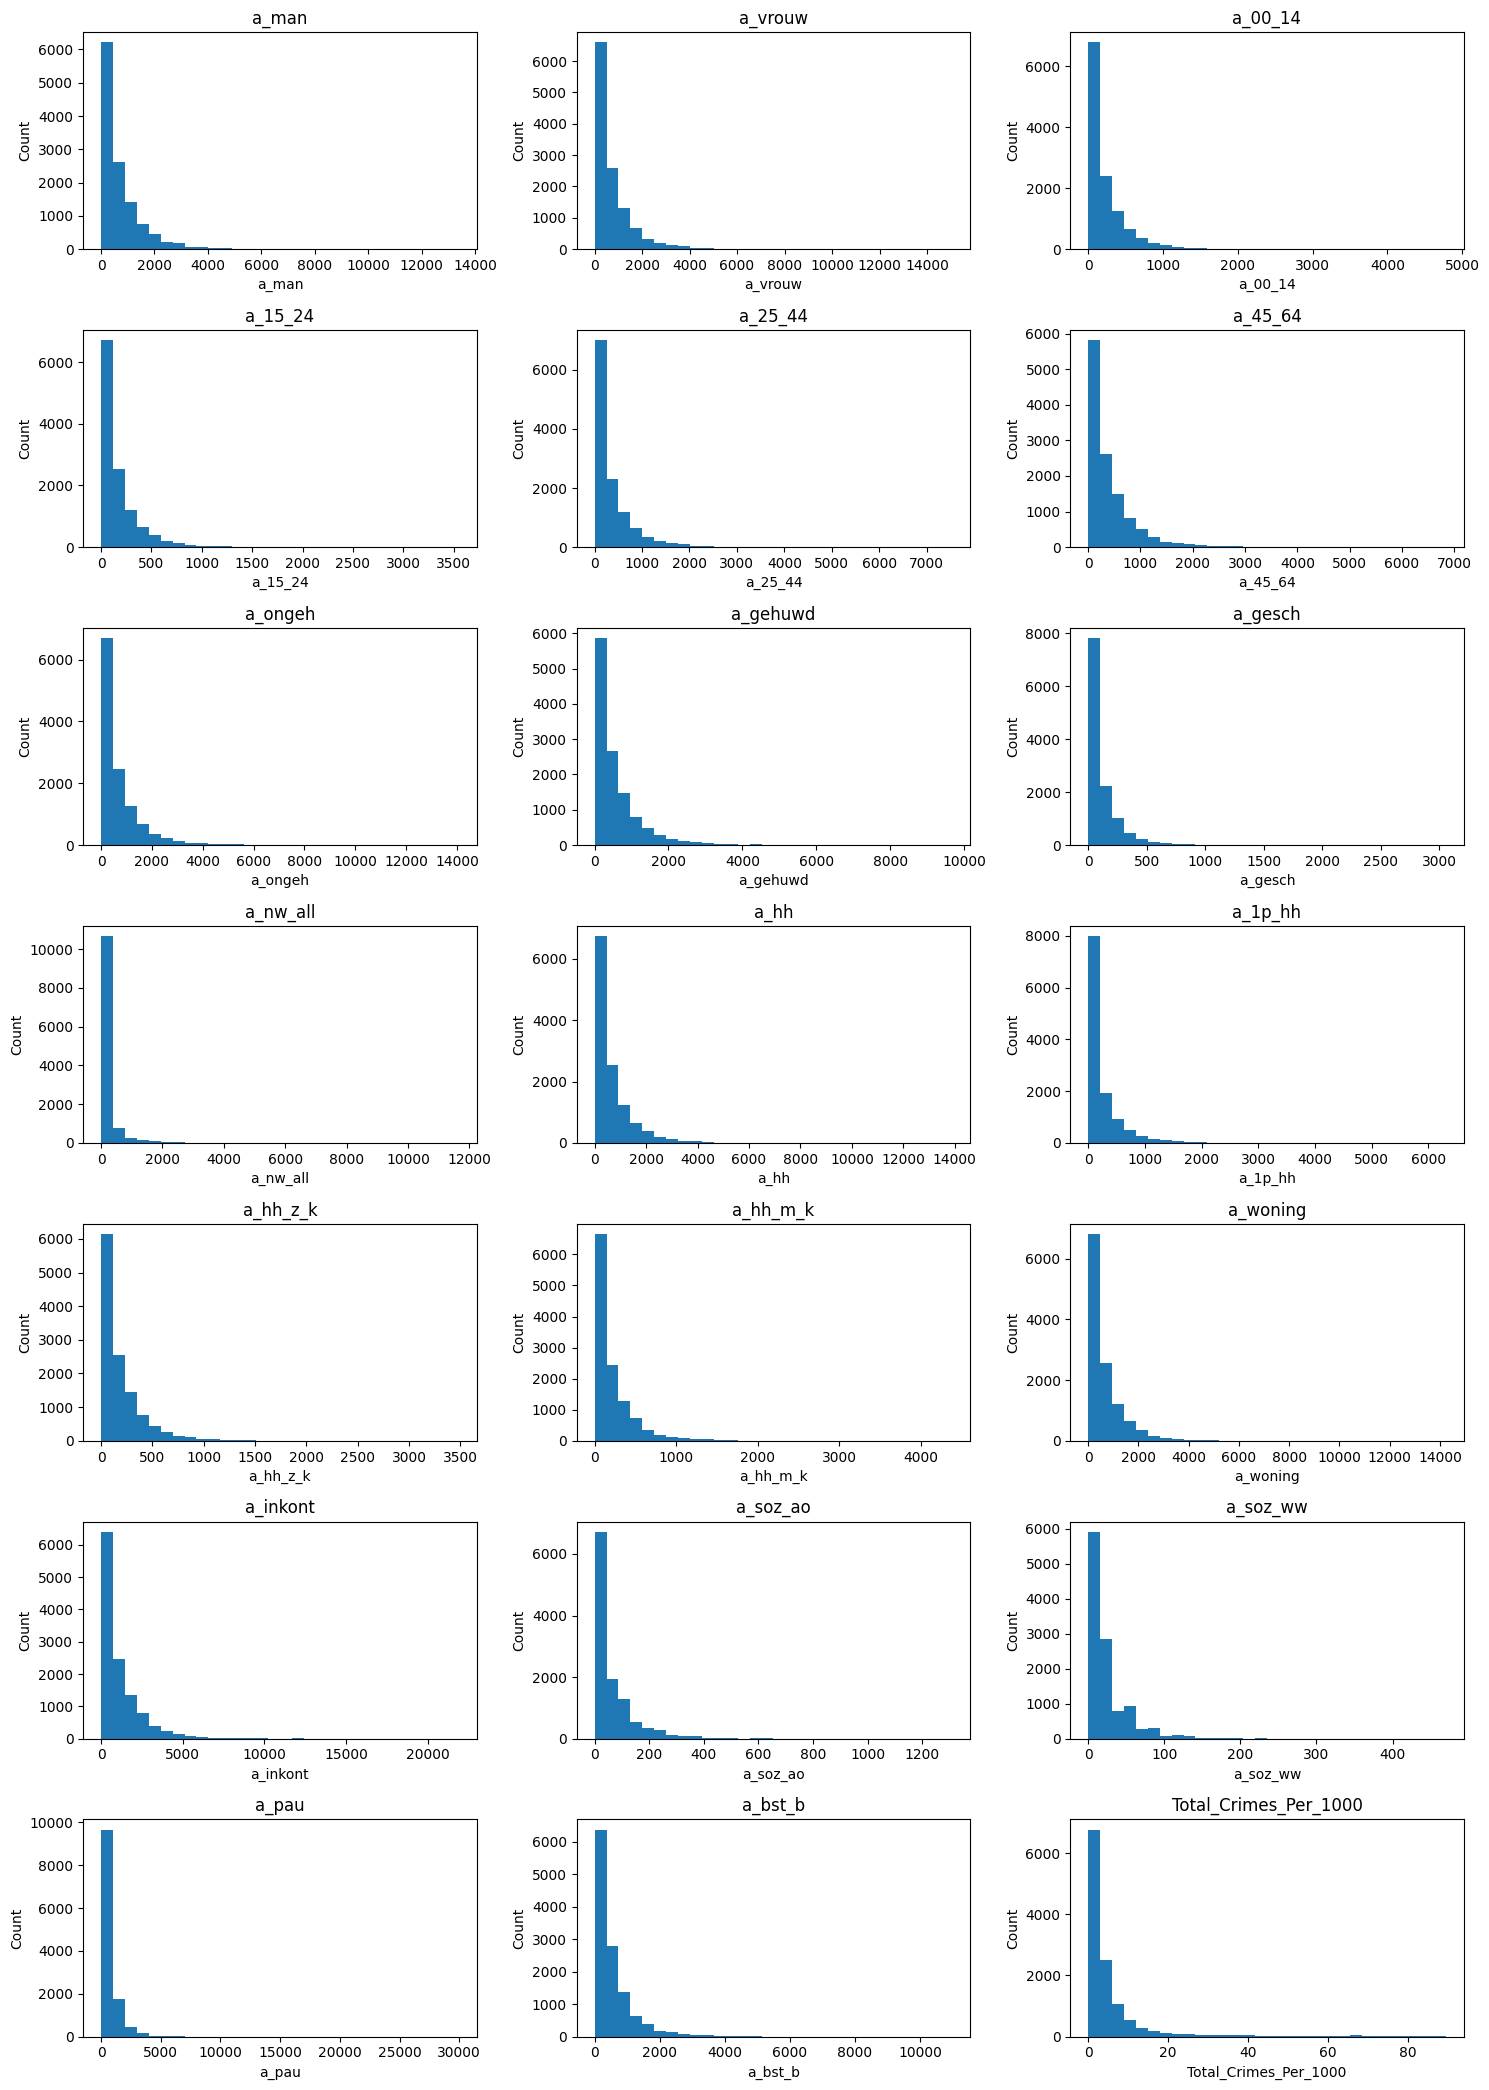

In [35]:
feature_cols = list(selected_features)
target_col = "Total_Crimes_Per_1000"

cols = feature_cols + [target_col]
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].hist(df[col].values, bins=30)
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


### ElasticNet

In [36]:
#elasticNet

elastic = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=None,
    cv=5,
    random_state=random_state
)

elastic.fit(X_train_final, y_train)
y_pred_elastic = elastic.predict(X_test_final)

print("ElasticNet Results:")
print("R2 Score:", r2_score(y_test, y_pred_elastic))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_elastic))
print("Best Alpha:", elastic.alpha_)
print("Best L1 Ratio:", elastic.l1_ratio_)



/Users/kay/Documents/GitHub/ML-Final_Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/Users/kay/Documents/GitHub/ML-Final_Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.064e+01, tolerance: 7.831e+01
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kay/Documents/GitHub/ML-Final_Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

ElasticNet Results:
R2 Score: 0.2790678158326171
Mean Squared Error: 65.49119612397007
Best Alpha: 0.004321760462877142
Best L1 Ratio: 0.7


/Users/kay/Documents/GitHub/ML-Final_Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+05, tolerance: 9.429e+01
  model = cd_fast.enet_coordinate_descent(


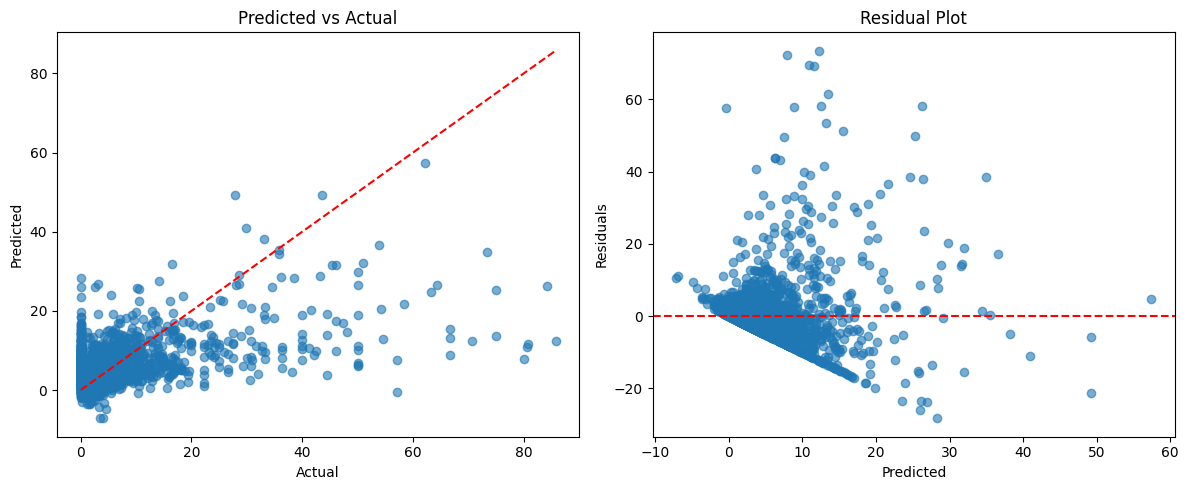

In [37]:

residuals = y_test - y_pred_elastic

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_elastic, alpha=0.6)
plt.plot([y_test.min(),y_test.max()],[y_test.min(), y_test.max()],'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")


plt.subplot(1, 2, 2)
plt.scatter(y_pred_elastic, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()


### Random Forest

In [38]:
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_regressor.fit(X_train_final, y_train)

rf_train_r2 = rf_regressor.score(X_train_final, y_train)
rf_test_r2 = rf_regressor.score(X_test_final, y_test)

print(f"Training R2: {rf_train_r2:.4f}")
print(f"Test R2: {rf_test_r2:.4f}")
print(f"Overfitting gap: {rf_train_r2 - rf_test_r2:.4f}")

y_pred = rf_regressor.predict(X_test_final)
rmse = mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")


Training R2: 0.8974
Test R2: 0.2700
Overfitting gap: 0.6274
Test RMSE: 66.3154


In [39]:
param_grid_rf = {
    'max_depth': [5, 10, 15, 20, None],
    'n_estimators': [50, 100, 200]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=random_state, n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_final, y_train)

print(f"\nBest parameters:")
print(f"  max_depth: {grid_rf.best_params_['max_depth']}")
print(f"  n_estimators: {grid_rf.best_params_['n_estimators']}")

rf_tuned_train_r2 = grid_rf.score(X_train_final, y_train)
rf_tuned_test_r2 = grid_rf.score(X_test_final, y_test)
print(f"Training R2: {rf_tuned_train_r2:.4f}")
print(f"Test R2: {rf_tuned_test_r2:.4f}")
print(f"Accuracy difference: {rf_tuned_train_r2 - rf_tuned_test_r2:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best parameters:
  max_depth: 10
  n_estimators: 200
Training R2: 0.7199
Test R2: 0.2831
Accuracy difference: 0.4369


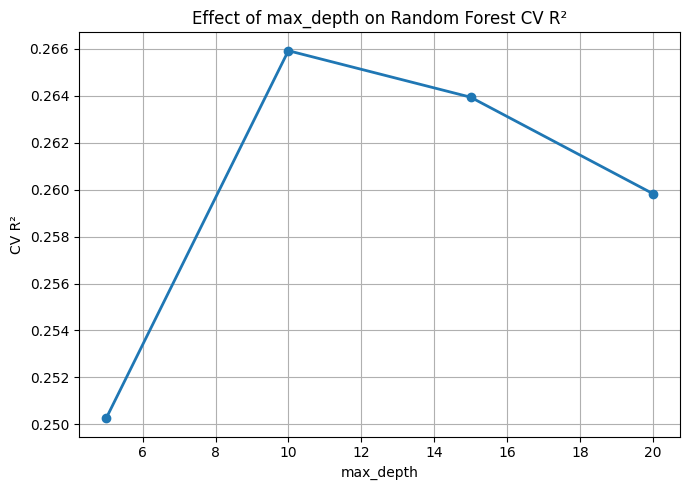

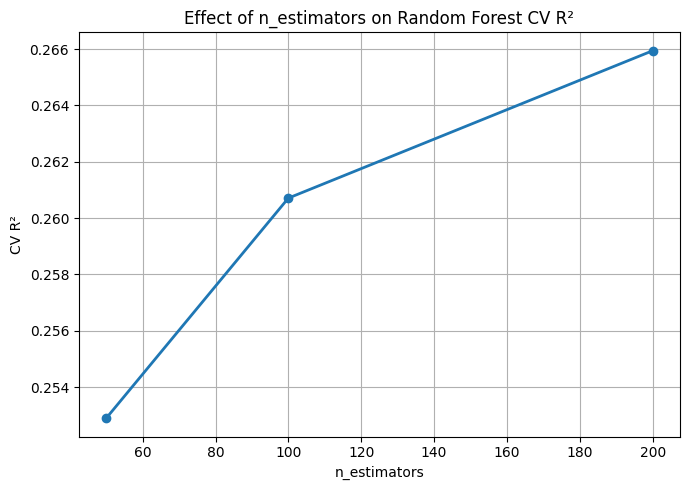

In [40]:
results = pd.DataFrame(grid_rf.cv_results_)

plt.figure(figsize=(7,5))

depth_scores = results.groupby("param_max_depth")["mean_test_score"].mean()

plt.plot(depth_scores.index, depth_scores.values, marker='o', linewidth=2)
plt.xlabel("max_depth")
plt.ylabel("CV R²")
plt.title("Effect of max_depth on Random Forest CV R²")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))

est_scores = results.groupby("param_n_estimators")["mean_test_score"].mean()

plt.plot(est_scores.index, est_scores.values, marker='o', linewidth=2)
plt.xlabel("n_estimators")
plt.ylabel("CV R²")
plt.title("Effect of n_estimators on Random Forest CV R²")
plt.grid(True)
plt.tight_layout()
plt.show()
